In [2]:
!pip install yfinance
!pip install ta
!pip install mpl_finance

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import ta
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

In [10]:
#Funció de preprocessat si venim de meta trading 5

def preprocessing(name):
    df = pd.read_csv(name,delimiter="\t", index_col = "<DATE>", parse_dates = True).dropna()
    #Eliminem les dues ultimes columnes
    df = df.iloc[:,:-2]
    #Renombrem
    df.columns = ["open","high","low","close","volume"]
    df.index.name = "time"
    return df

In [12]:
#Funció de preprocessat si venim de yahoo

def preprocessing_yf(symbol):
    df = yf.download(symbol).dropna()
    df.columns = ["open","high","low","close","adj close","volume"]
    df.index.name = "time"
    del df["adj close"]
    return df

In [14]:
# Funció de característiques

def feature_engineering(df):
    df_copy = df.copy()
    df_copy["returns"] = df_copy["close"].pct_change(1)
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window=14, fillna=False)
    df_copy["rsi"] = RSI.rsi()
    return df_copy

In [16]:
# Drawdown
def drawdown_function(serie):
    cum = serie.dropna().cumsum() + 1
    runing_max = np.maximum.accumulate(cum)
    drawdown = cum / runing_max - 1
    return drawdown

In [20]:
# Back Test
def BackTest(serie, annualized_scalar = 252):
    sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
    sp500.name = "SP500"
    val = pd.concat((return_serie, sp500),axis = 1).dropna()
    drawdown = drawdown_function(return_serie)
    max_drawdown = -np.min(drawdown)*100

    fig, (cum,dra) = plt.subplots(1,2,figsize=(20,6))
    fig.suptitle("Backtesting", size = 20)
    cum.plot(serie.cumsum()*100, color = "#39B3C7")
    cum.plot(val["SP500"].cumsum()*100, color = "#B85A0F")
    cum.legend(["Portfolio", "SP500"])
    cum.set_title("Cumulative Return ", size = 13)
    cum.set_ylabel("Cumulative Rerturn %", size = 11)
    plt.fill_between(drawdown.index, drawdown*100, 0, drawdown, color = "#CE5757", alpha = 0.65)
    plt.title("Drawdown")
    plt.ylabel("Drawdawn en %")
    plt.show()
    sortino = np.sqrt(annualized_scalar)* serie.mean()/serie.loc[serie<0].std()
    beta = np.cov(val[["return","SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)
    alpha = (annualized_scalar * (serie.mean() - beta * serie.mean()))

    print(f"Sortino : {np.round(sortino,3)}")
    print(f"Beta : {np.round(beta,3)}")
    print(f"Alpha : {np.round(alpha,3)} %")
    print(f"MaxDrawdown : {np.round(max_drawdown,3)} %")



In [39]:
def get_dataframe(input, mt5=False, yf=False):

    if mt5:
        df = preprocessing(input)
  
    if yf:
        df = preprocessing_yf(input)
    return df


In [373]:
currency = input("introdueix l'actiu a estudiar: ")
df = get_dataframe(currency, mt5=False, yf = True)
caracteristics = feature_engineering(df)
df.head()


introdueix l'actiu a estudiar:  EURUSD=X


[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
time,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,0


In [375]:
caracteristics.head()

,open,high,low,close,volume,returns,SMA 15,SMA 60,MSD 10,MSD 30,rsi
time,,,,,,,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,0,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,1.196101,1.210903,1.194600,1.208897,0,0.010360,NaN,NaN,NaN,NaN,NaN
2003-12-03,1.209000,1.213003,1.207700,1.212298,0,0.002813,NaN,NaN,NaN,NaN,NaN
2003-12-04,1.212004,1.214403,1.204398,1.208094,0,-0.003467,NaN,NaN,NaN,NaN,NaN
2003-12-05,1.207802,1.219096,1.206593,1.218695,0,0.008775,NaN,NaN,NaN,NaN,NaN


quin any vols visualitzar (o interval, ex. '2010:2015')?  1980:2024


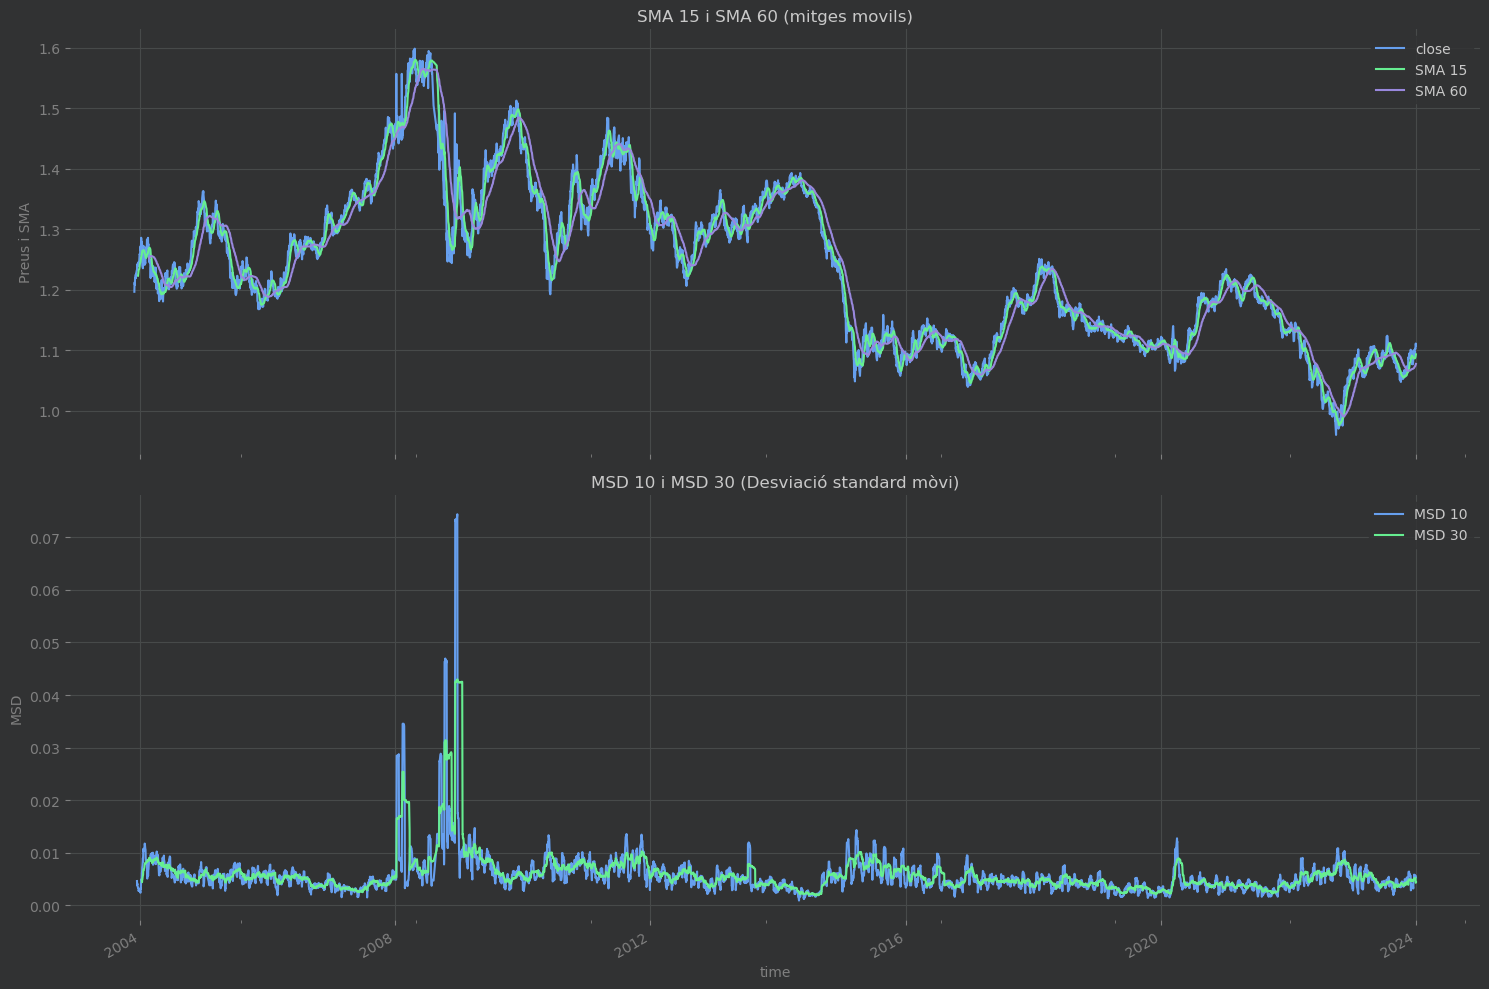

In [387]:
year = input("quin any vols visualitzar (o interval, ex. '2010:2015')? ")

# Comprovar si l'usuari ha introduït un interval (format: 'YYYY:YYYY')
if ':' in year:
    start_year, end_year = year.split(':')
    start_year = int(start_year.strip())
    end_year = int(end_year.strip())-1
    
    # Filtrar l'interval d'anys
    filtered_data = caracteristics.loc[str(start_year):str(end_year)]
else:
    # Tractar-ho com un any únic
    filtered_data = caracteristics.loc[year]

# Plot de les dades filtrades
# Crear subplots, dos gràfics un sobre l'altre
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Primer gràfic per les SMA
filtered_data[["close", "SMA 15", "SMA 60"]].plot(ax=ax1)
ax1.set_title("SMA 15 i SMA 60 (mitges movils)")
ax1.set_ylabel("Preus i SMA")

# Segon gràfic per les MSD
filtered_data[["MSD 10", "MSD 30"]].plot(ax=ax2)
ax2.set_title("MSD 10 i MSD 30 (Desviació standard mòvi)")
ax2.set_ylabel("MSD")

# Mostrar els gràfics
plt.tight_layout()
plt.show()



In [447]:
def support_resistance(df, duration=5, spread=0):
    """EL DATAFRAME NECESITA TENER los siguientes nombres de columna: alta, baja, cierre"""

    # Support and resistance building
    df["support"] = np.nan
    df["resistance"] = np.nan

    df.loc[(df["low"].shift(5) > df["low"].shift(4)) &
           (df["low"].shift(4) > df["low"].shift(3)) &
           (df["low"].shift(3) > df["low"].shift(2)) &
           (df["low"].shift(2) > df["low"].shift(1)) &
           (df["low"].shift(1) > df["low"].shift(0)), "support"] = df["low"]

    df.loc[(df["high"].shift(5) < df["high"].shift(4)) &
           (df["high"].shift(4) < df["high"].shift(3)) &
           (df["high"].shift(3) < df["high"].shift(2)) &
           (df["high"].shift(2) < df["high"].shift(1)) &
           (df["high"].shift(1) < df["high"].shift(0)), "resistance"] = df["high"]

    # Create Simple moving average 30 days
    df["SMA 15"] = df["close"].rolling(30).mean()

    # Create Simple moving average 60 days
    df["SMA 60"] = df["close"].rolling(60).mean()

    df["rsi"] = ta.momentum.RSIIndicator(df["close"], window=10).rsi()

    # RSI yesterday
    df["rsi yersteday"] = df["rsi"].shift(1)

    # Create the signal
    df["signal"] = 0

    df["smooth resistance"] = df["resistance"].fillna(method="ffill")
    df["smooth support"] = df["support"].fillna(method="ffill")

    # Buying conditions
    condition_1_buy = (df["close"].shift(1) < df["smooth resistance"].shift(1)) & \
                      (df["smooth resistance"] * (1 + 0.5 / 100) < df["close"])
    condition_2_buy = df["SMA 15"] > df["SMA 60"]
    condition_3_buy = df["rsi"] < df["rsi yersteday"]

    # Selling conditions
    condition_1_sell = (df["close"].shift(1) > df["smooth support"].shift(1)) & \
                       (df["smooth support"] * (1 + 0.5 / 100) > df["close"])
    condition_2_sell = df["SMA 15"] < df["SMA 60"]
    condition_3_sell = df["rsi"] > df["rsi yersteday"]

    # Assigning signals
    # df.loc[condition_1_buy & condition_2_buy & condition_3_buy, "signal"] = 1
    # df.loc[condition_1_sell & condition_2_sell & condition_3_sell, "signal"] = -1
    df.loc[ condition_2_buy  , "signal"] = 1
    df.loc[ condition_2_sell , "signal"] = -1

    # Print the rows with buy signals
    print(df[df["signal"] == 1])

    # Calculating returns
    df["pct"] = df["close"].pct_change(1)
    df["return"] = np.array([df["pct"].shift(i) for i in range(duration)]).sum(axis=0) * (df["signal"].shift(duration))
    
    # Adjusting returns for spread
    df.loc[df["return"] == -1, "return"] = df["return"] - spread
    df.loc[df["return"] == 1, "return"] = df["return"] - spread

    return df["return"]

                open      high       low     close  volume   returns  \
time                                                                   
2004-02-20  1.275803  1.276096  1.250297  1.254202       0 -0.016856   
2004-02-23  1.250094  1.259398  1.245702  1.257197       0  0.002389   
2004-02-24  1.257197  1.271100  1.252897  1.267797       0  0.008431   
2004-02-25  1.267893  1.270406  1.248393  1.249703       0 -0.014271   
2004-02-26  1.250094  1.251799  1.239695  1.244803       0 -0.003921   
...              ...       ...       ...       ...     ...       ...   
2023-12-25  1.102657  1.104240  1.099989  1.102657       0  0.001852   
2023-12-26  1.102026  1.103997  1.100958  1.102026       0 -0.000573   
2023-12-27  1.104301  1.112248  1.102925  1.104301       0  0.002065   
2023-12-28  1.110864  1.113945  1.107101  1.110864       0  0.005943   
2023-12-29  1.106819  1.108647  1.104326  1.106819       0 -0.003641   

              SMA 15    SMA 60    MSD 10    MSD 30        rsi  

<Axes: xlabel='time'>

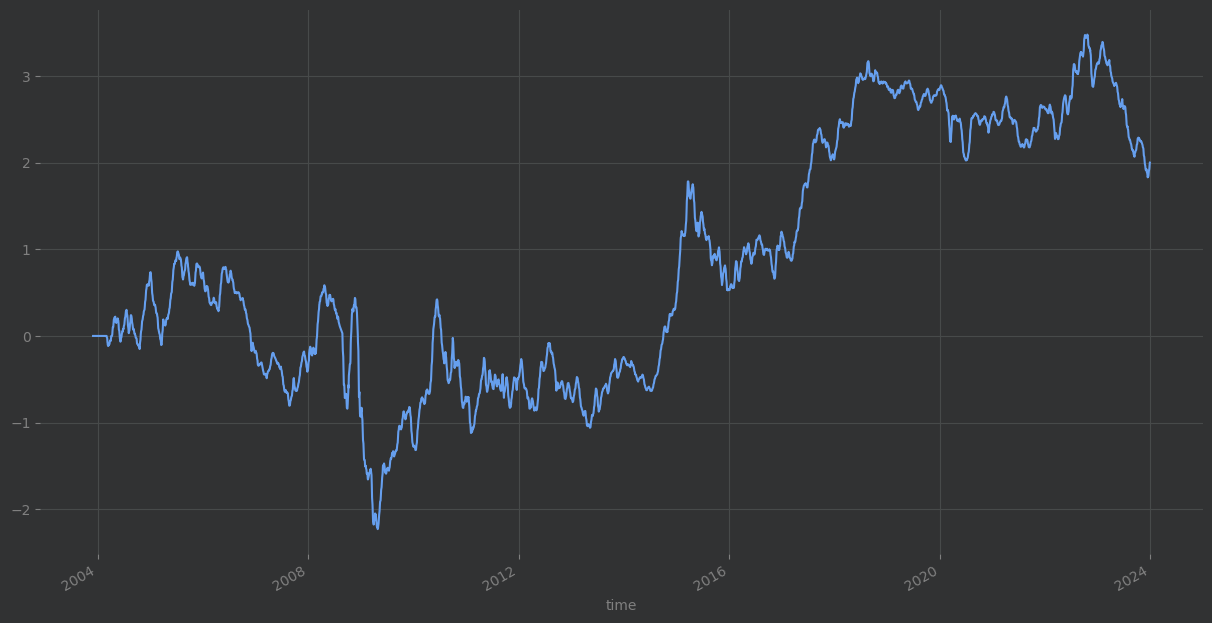

In [449]:
returns = support_resistance(filtered_data, duration=10, spread=0.0001)
returns.fillna(value=0).cumsum().plot(figsize=(15,8))


idx open =  DatetimeIndex(['2004-02-20', '2004-02-23', '2004-02-24', '2004-02-25',
               '2004-02-26', '2004-02-27', '2004-03-01', '2004-03-02',
               '2004-03-03', '2004-03-04',
               ...
               '2023-12-18', '2023-12-19', '2023-12-20', '2023-12-21',
               '2023-12-22', '2023-12-25', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='time', length=2559, freq=None)


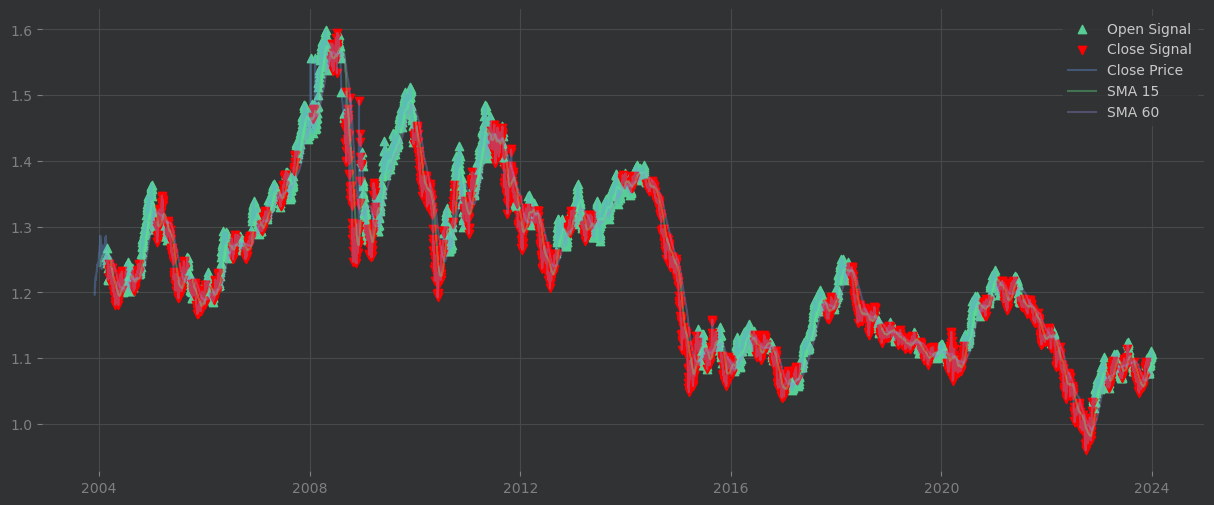

In [453]:
# Comprovar si l'usuari ha introduït un interval (format: 'YYYY:YYYY')
if ':' in year:
    start_year, end_year = year.split(':')
    start_year = int(start_year.strip())
    end_year = int(end_year.strip())-1
    
    # Filtrar l'interval d'anys
    filtered_data = filtered_data.loc[str(start_year):str(end_year)]
else:
    # Tractar-ho com un any únic
    filtered_data = filtered_data.loc[year]


# Seleccionar tota la senyal en una llista d'índexs per representar només aquests punts
idx_open = filtered_data.loc[filtered_data["signal"] == 1].index
idx_close = filtered_data.loc[filtered_data["signal"] == -1].index


print("idx open = ",idx_open)
# Adaptar la mida del gràfic
plt.figure(figsize=(15,6))

# Representar els punts de la senyal 'buy' en verd i 'sell' en vermell
plt.scatter(idx_open, filtered_data.loc[idx_open]["close"], color="#57CE95", marker="^", label="Open Signal")
plt.scatter(idx_close, filtered_data.loc[idx_close]["close"], color="red", marker="v", label="Close Signal")

# Representar les línies de preus i mitjanes mòbils
plt.plot(filtered_data.index, filtered_data["close"], alpha=0.35, label="Close Price")
plt.plot(filtered_data.index, filtered_data["SMA 15"], alpha=0.35, label="SMA 15")
plt.plot(filtered_data.index, filtered_data["SMA 60"], alpha=0.35, label="SMA 60")

# Afegir llegenda
plt.legend()

# Mostrar el gràfic
plt.show()